---
title: Creating Timeseries with NLDAS-3 Sample Data
author: Rishi Anand, Siddharth Chaudhary
date: August 5, 2024
execute:
   freeze: true
---

## Run this notebook

You can launch this notebook in VEDA JupyterHub by clicking the link below.

[Launch in VEDA JupyterHub (requires access)](https://hub.openveda.cloud/hub/user-redirect/git-pull?repo=https://github.com/NASA-IMPACT/veda-docs&urlpath=lab/tree/veda-docs/user-guide/notebooks/datasets/nldas_time_series.ipynb&branch=main) 

<details><summary>Learn more</summary>
    
### Inside the Hub

This notebook was written on the VEDA JupyterHub and as such is designed to be run on a jupyterhub which is associated with an AWS IAM role which has been granted permissions to the VEDA data store via its bucket policy. The instance used provided 16GB of RAM. 

See (VEDA Analytics JupyterHub Access)[https://nasa-impact.github.io/veda-docs/veda-jh-access.html] for information about how to gain access.

### Outside the Hub

The data is in a protected bucket. Please request access by emailng aimee@developmentseed.org or alexandra@developmentseed.org and providing your affiliation, interest in or expected use of the dataset and an AWS IAM role or user Amazon Resource Name (ARN). The team will help you configure the cognito client.

You should then run:

```
%run -i 'cognito_login.py'
```
    
</details>

## About the Data

NLDAS is a widely used land modeling environment that generates
estimates of land surface fluxes and states such as soil moisture,
snow, and streamflow.  These estimates are critical for drought
and flood monitoring, water availability and water resource
management, climate assessments, and other uses.  NLDAS-3 is
the next generation version of NLDAS-2, and offers significant
improvements such as improved spatial resolution (12.5km to 1km),
expanded domain (CONUS to North and Central America), reduced
data latency (3.5 days to near real-time), and assimilation of
NASA remote sensing data, among others. (see Earthdata VEDA Data
Story (https://www.earthdata.nasa.gov/dashboard/stories/nldas)). Please note that the NLDAS-3 precipitation data provided here
is a sample dataset still in development, and will not be the final NLDAS-3 product when it is released.
 
This notebook is intended to visualize the sample NLDAS-3 monthly-averaged precipitation forcing data via a timeseries.

### Using the VEDA STAC to Create a Timeseries
If you need to do analysis over an AOI you can do so via Project VEDA's STAC.

### Approach
1. Define the URL where the data is stored.
2. Make sure the dataset is the size we expected.
3. Define an Area of Interest.
4. Retrieve the dataset's statistics for the AOI.
5. Plot the relevant statistic.

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

## Querying the STAC API

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://openveda.cloud/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://openveda.cloud/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for NLDAS-3 data
collection_name = "nldas3"

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
asset_name = "cog_default"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# Print the id of the collection to the console
collection['id']

'nldas3'

In [4]:
# Create a function that would search for a data collection in the VEDA STAC API

# First, we need to define the function
# The name of the function = "get_item_count"
# The argument that will be passed through the defined function = "collection_id"
def get_item_count(collection_id):
   
    # Set a counter for the number of items existing in the collection
    count = 0

    # Define the path to retrieve the granules (items) of the collection of interest in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path
        response = requests.get(items_url)

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()
       
        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break
       
        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]


    # Return the information about the total number of granules found associated with the collection
    return count

Now let's check how many total items are available. 

In [5]:
# Apply the function created above "get_item_count" to the data collection
number_of_items = get_item_count(collection_name)

# Get the information about the number of granules found in the collection
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=800").json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 252 items


In [6]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[100]

{'id': 'nldas3_LIS_HIST_201308',
 'bbox': [-168.98000671647551,
  7.019999961559591,
  -51.93999145246978,
  72.06000091582078],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://staging.openveda.cloud/api/stac/collections/nldas3'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging.openveda.cloud/api/stac/collections/nldas3'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging.openveda.cloud/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://staging.openveda.cloud/api/stac/collections/nldas3/items/nldas3_LIS_HIST_201308'},
  {'title': 'Map of Item',
   'href': 'https://staging.openveda.cloud/api/raster/collections/nldas3/items/nldas3_LIS_HIST_201308/map?bidx=1&assets=cog_default&unscale=False&colormap=%7B%221%22%3A+%5B120%2C+120%2C+120%5D%2C+%222%22%3A+%5B130%2C+65%2C+0%5D%2C+%223%22%3A+%5B66%2C+207%2C+56%5D%2C+%224%22%3A+%5B245%2C+239%2C+0%5D%

In [7]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (Dallas, TX polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the Dallas, TX boundaries to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (Dallas, TX polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Print the result
    #print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information
    return {
        **result["properties"],
        "datetime": item["properties"]["end_datetime"][:10],
    }

In [8]:
# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["end_datetime"])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2021-12-31T00:00:00


Let's create a bounding box to explore the area of interest (AOI) in Texas

In [9]:
# The Area of Interest (AOI) is set to Dallas, Texas (USA)
texas_dallas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                # [longitude, latitude]
                [-96.1, 32.28],  # Southeast Bounding Coordinate
                [-96.1, 33.28],  # Northeast Bounding Coordinate
                [-97.58, 33.28], # Northwest Bounding Coordinate
                [-97.58, 32.28],  # Southwest Bounding Coordinate
                [-96.1, 32.28]   # Closing the polygon at the Southeast Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}

Let's visualize the AOI we have just created using `folium` 

In [10]:
# Create a new map to display the generated polygon
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        32.81,-96.93, # coordinates for Dallas, Texas area
    ],

    # Set the zoom value
    zoom_start=9, # zoom in or out by increasing or decreasing the value here
)

# Insert the Dallas, TX polygon to the map
folium.GeoJson(texas_dallas_aoi, name="Texas, Dallas").add_to(aoi_map)

# Visualize the map
aoi_map

## Visualizing the Data as a Time Series

With the function provided above, we can generate statistics for our AOI. In the example below, we'll explore sample statistics available from one of the tiles. 

In [11]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the "texas_dallas_aoi" polygon
stats = [generate_stats(item, texas_dallas_aoi) for item in items]

stats[0]

CPU times: user 945 ms, sys: 141 ms, total: 1.09 s
Wall time: 3min 10s


{'statistics': {'b1': {'min': 5.5441460609436035,
   'max': 40.02827072143555,
   'mean': 18.9648380279541,
   'count': 925.0999755859375,
   'sum': 17544.37109375,
   'std': 7.4039084036512905,
   'median': 18.58078956604004,
   'majority': 5.5441460609436035,
   'minority': 5.5441460609436035,
   'unique': 964.0,
   'histogram': [[72.0,
     155.0,
     139.0,
     161.0,
     148.0,
     120.0,
     76.0,
     56.0,
     22.0,
     15.0],
    [5.5441460609436035,
     8.992558479309082,
     12.440971374511719,
     15.889383316040039,
     19.33779525756836,
     22.78620719909668,
     26.234621047973633,
     29.683032989501953,
     33.131446838378906,
     36.579856872558594,
     40.02827072143555]],
   'valid_percent': 97.57,
   'masked_pixels': 24.0,
   'valid_pixels': 964.0,
   'percentile_2': 6.959613800048828,
   'percentile_98': 35.4062614440918}},
 'datetime': '2021-12-31'}

In [12]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-12-31,5.544146,40.028271,18.964838,925.099976,17544.371094,7.403908,18.580790,5.544146,5.544146,964.0,"[[72.0, 155.0, 139.0, 161.0, 148.0, 120.0, 76....",97.57,24.0,964.0,6.959614,35.406261,2021-12-31
1,2021-11-30,29.220421,90.284607,57.790234,925.099976,53461.742188,13.098977,59.066620,29.220421,29.220421,964.0,"[[54.0, 83.0, 115.0, 113.0, 133.0, 161.0, 166....",97.57,24.0,964.0,32.481430,80.630257,2021-11-30
2,2021-10-31,71.620056,130.268082,95.405159,925.099976,88259.312500,9.503741,93.906479,71.620056,71.620056,964.0,"[[10.0, 52.0, 171.0, 316.0, 201.0, 106.0, 50.0...",97.57,24.0,964.0,80.306641,120.759964,2021-10-31
3,2021-09-30,13.006416,28.573898,18.290234,925.099976,16920.294922,3.538529,17.590103,13.006416,13.006416,964.0,"[[133.0, 241.0, 116.0, 110.0, 102.0, 102.0, 74...",97.57,24.0,964.0,13.719144,25.504732,2021-09-30
4,2021-08-31,80.948761,148.701004,109.796944,925.099976,101573.148438,13.211540,106.925323,80.948761,80.948761,964.0,"[[29.0, 70.0, 175.0, 254.0, 145.0, 101.0, 78.0...",97.57,24.0,964.0,86.764038,137.815720,2021-08-31


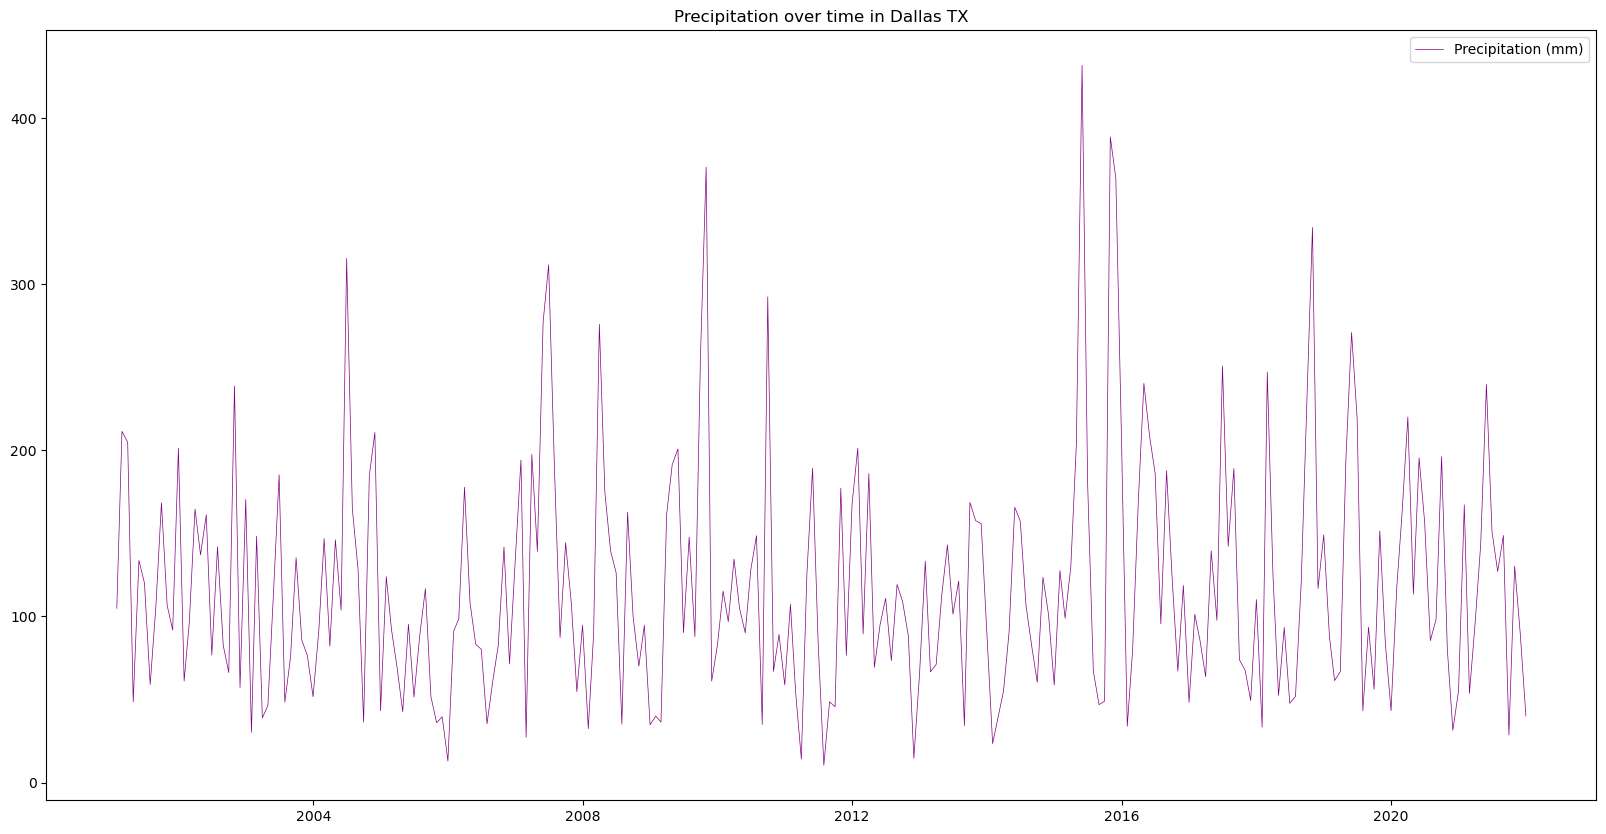

In [14]:
# Determine the width and height of the plot using the 'matplotlib' library
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10)) 

# Plot the time series analysis of the monthly precipitation changes in Dallas, Texas
plt.plot(
    df["date"], # X-axis: date
    df["max"], # Y-axis: Precipitation value
    color="purple", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="Precipitation (mm)", # Legend label
)

plt.title('Precipitation over time in Dallas TX')

# Display legend
plt.legend()

plt.show()